# Using Machine Learning to Predict Fitbit Sleep Scores

In this project I'm going to apply various Machine Learning models to predict Fitbit Sleep Scores based on a sample of almost one year of sleep score data. I will compare the accuracies of teh different models and look into the feature importances in each of the models.

## Import the relevant libraries and data

In [3]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Import the data
sleep_data = pd.read_csv('combined.csv')

## Isolate the Fitbit App data

In [5]:
sleep_data.head()

,Unnamed: 0,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,0,2020-07-02,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,1,2020-07-01,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2,2020-06-30,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,3,2020-06-29,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,4,2020-06-28,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In [6]:
# Obtain the data available through the app
app_data = sleep_data[sleep_data.columns[2:10]]

In [7]:
app_data.head()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,456,42,37,498,94,271,91,86.0
1,412,88,32,500,79,208,125,77.0
2,412,61,26,473,91,242,79,78.0
3,342,59,26,401,71,196,75,76.0
4,530,108,39,638,98,305,127,82.0


In [8]:
# Obtain the subset of independent variables used for MLR previously
app_reduced = app_data.drop(columns=['Minutes Asleep', 'Number of Awakenings', 'Minutes Light Sleep'])

In [9]:
app_reduced.head()

,Minutes Awake,Time in Bed,Minutes REM Sleep,Minutes Deep Sleep,overall_score
0,42,498,94,91,86.0
1,88,500,79,125,77.0
2,61,473,91,79,78.0
3,59,401,71,75,76.0
4,108,638,98,127,82.0


## Visualise the relationships between features and sleep score

Before moving on to the analysis and building of Machine Learning models I want to have a look at the relationship that each individual feature has with the overall sleep score to get a sense of their impact on it.

In [10]:
# Define a function to plot the scatterplots of the relationships between all independent variables and the dependent
# variable
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,60))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

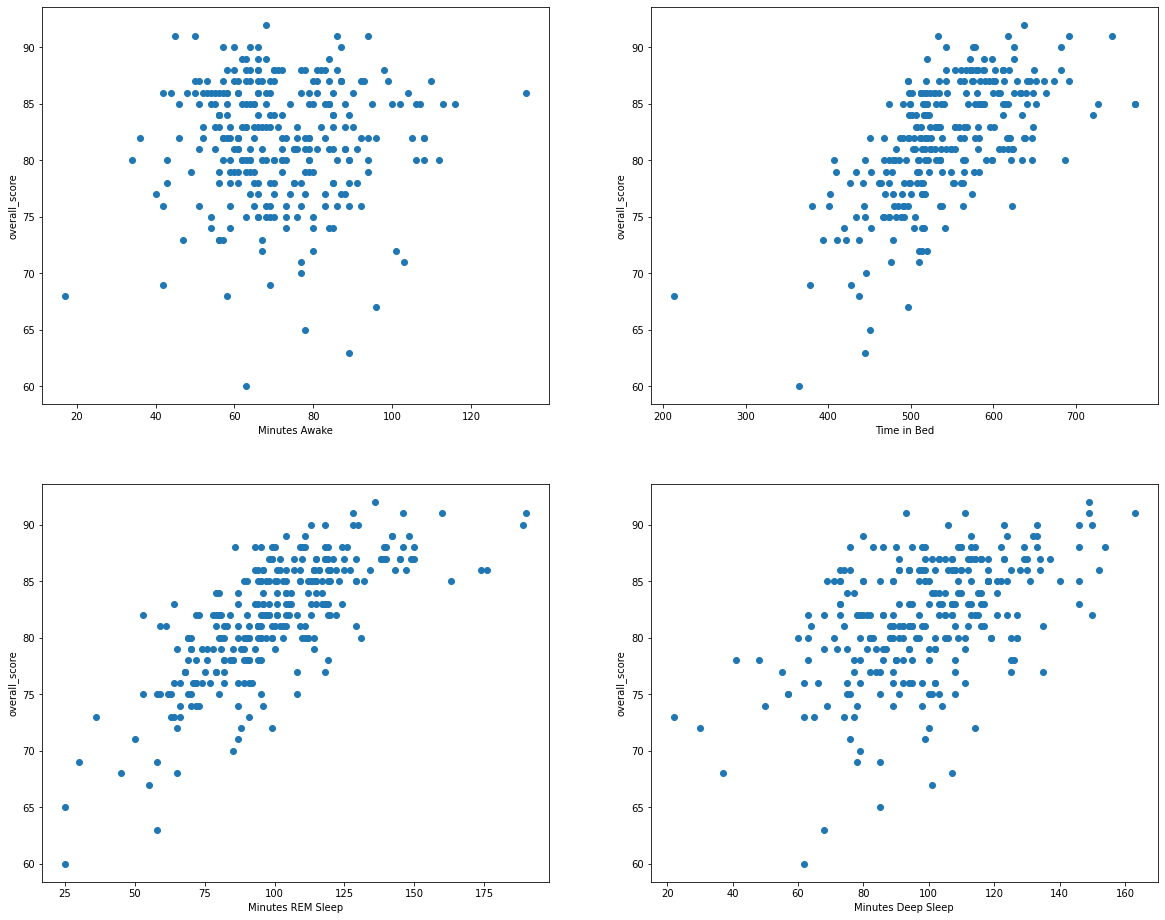

In [11]:
# Call the function with the reduced app data DataFrame and subplots in a grid of two columns
plot_relationships(app_reduced, 2)

Taken by themselves, Time in Bed and Minutes REM Sleep seem to have the strongest positive relationships with the overall sleep score. Generally speaking this makes sense because more time in bed should lead to more sleep, and therefore more quality sleep, and REM sleep has been found to be extremely important for many restorative functions and memory formation. (Elaborate more!)

In [12]:
# Inspect the correlations
app_reduced.corr()

,Minutes Awake,Time in Bed,Minutes REM Sleep,Minutes Deep Sleep,overall_score
Minutes Awake,1.000000,0.652037,0.160597,0.303564,0.033523
Time in Bed,0.652037,1.000000,0.583927,0.513741,0.616046
Minutes REM Sleep,0.160597,0.583927,1.000000,0.433558,0.745308
Minutes Deep Sleep,0.303564,0.513741,0.433558,1.000000,0.503672
overall_score,0.033523,0.616046,0.745308,0.503672,1.000000


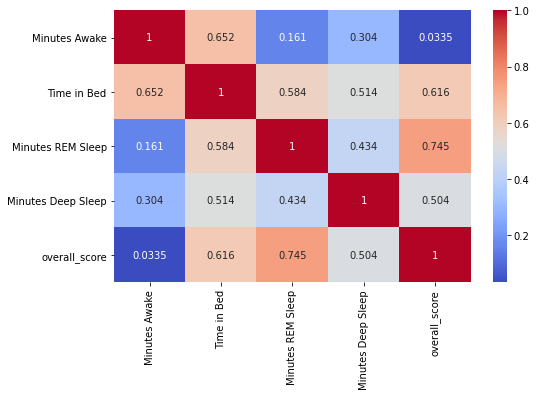

In [13]:
# Inspect the correlations
plt.figure(figsize=(8, 5))
sns.heatmap(app_reduced.corr(), annot=True, cmap='coolwarm', fmt='.3g')

## Inspect sleep score distribution

In [14]:
# Find spread of sleep score values
spread = int(max(app_reduced.overall_score) - min(app_reduced.overall_score))
spread

32

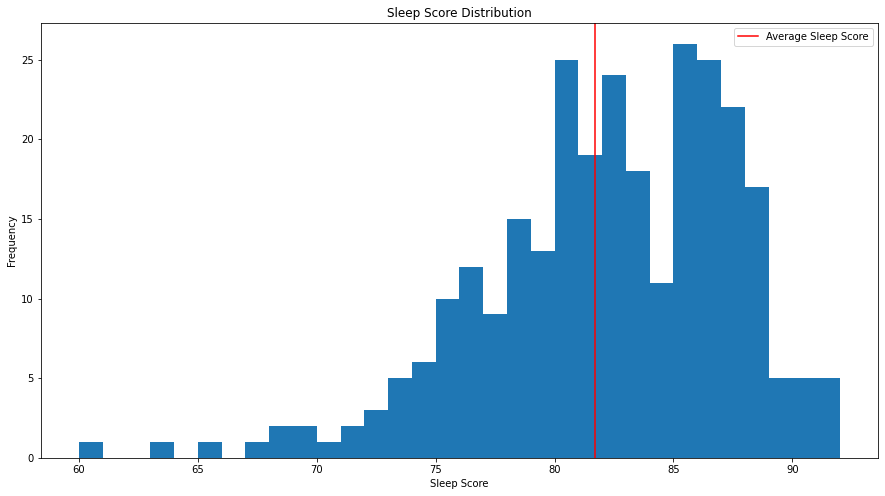

In [15]:
# Plot sleep score histogram and its mean
plt.figure(figsize=(15,8))
plt.hist(app_reduced.overall_score, bins=spread)
plt.axvline(app_reduced.overall_score.mean(), color='r', label='Average Sleep Score')
plt.xlabel('Sleep Score')
plt.ylabel('Frequency')
plt.title('Sleep Score Distribution')
plt.legend()

The distribution of sleep scores is skewed to the left. This makes sense because bad night sleeps are more likely to occur than exceptionally good ones due to multiple reasons such as staying out late, having to gte up extremely early, etc. Given that the average sleep score in the data set is already relatively high at 82 and the upper limit being 100, it is by definition difficult to have many outliers that lie above the average.

## Split the data into training, validation and test set

Most data science projects that can be found online provide a training set and a test set that are well separated and that leave out the variable to be predicted in the test set, so as to assure no spillover effects. The training set can then be split into training and validation set without worrying about the test set because that has been neatly separated out already. Because I am solely relying on the data I was able to obtain from Fitbit, I have to split the data into training, validation and test set myself. There are many ways to do this but the most straight forward is to use the train_test_split twice.

Furthermore, when building Machine Learning models it is crictical to make sure that information about test (and validation) data does not spill over into the the training stage of model building. Because the scaling of features always involves some information about the data that is used for the scaling (i.e. mean, variance, maximum or minimum values) we have to make sure that the test and validation set are separated from the training set before we scale the data. Therefore, before I proceed I split the data into training, validation and test set. 

In [16]:
# Perform first split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(app_reduced[app_reduced.columns[:-1]], 
                                                              app_reduced['overall_score'], test_size=0.2, 
                                                              random_state=420)

In [17]:
# Perform the second split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=420)

In [18]:
# Check the lengths of the different subsets
len(X_train), len(X_valid), len(X_test)

(171, 57, 58)

Now that we have a training set, validation set and test set we can proceed as follows: Train models on the training data, measure their accuracy on the validation data, tweak the model to be more accurate and measure the new accuracy, once we're happy with its performance we measure its generalisability on the test data.

## Scaling the features

Although for the Machine Learning Models in this project feature scaling is not required, it is considered best practice to scale features when comparing different models and their performance.

In [19]:
# Create the scaler with object range of 0-1
scaler = MinMaxScaler()

# Fit and transform using the training data
scaler.fit_transform(X_train)

# Transform the validation and test features
scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.28125   , 0.54659498, 0.53939394, 0.53900709],
       [0.54166667, 0.47849462, 0.40606061, 0.53900709],
       [0.48958333, 0.63799283, 0.53939394, 0.68085106],
       [0.53125   , 0.68996416, 0.70909091, 0.64539007],
       [0.375     , 0.57526882, 0.68484848, 0.75886525],
       [0.71875   , 0.84767025, 0.51515152, 0.68794326],
       [0.40625   , 0.35483871, 0.23636364, 0.39007092],
       [0.625     , 0.71505376, 0.6969697 , 0.53900709],
       [0.4375    , 0.44623656, 0.28484848, 0.73049645],
       [0.45833333, 0.58243728, 0.27272727, 0.45390071],
       [0.5       , 0.5125448 , 0.54545455, 0.68085106],
       [0.55208333, 0.69713262, 0.51515152, 0.64539007],
       [0.63541667, 0.4265233 , 0.        , 0.44680851],
       [0.625     , 0.70430108, 0.57575758, 0.5106383 ],
       [0.38541667, 0.5125448 , 0.56969697, 0.41134752],
       [0.58333333, 0.52150538, 0.43030303, 0.53900709],
       [1.03125   , 1.        , 0.64848485, 0.77304965],
       [0.40625   , 0.32437276,

## Defining performance measures

The performance measures I want to use to compare the different ML models are Accuracy and Score. Average Error is added to the list as an extra.

In [20]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

Accuracy is typically used as a performance measure in classification problems and not regression problems because it refers to the proportion of correct predictions that the model makes. The ways I use accuracy for the regression models in this analysis is different. Accuracy for the regression models is a measure of how far off (in percentage terms) the prediction in sleep score will be from the actual sleep score, on average. For example, if the actual sleep score is 80 and the model has an accuracy of 96%, meaning that on average it is 4% off, the model is expected to make a prediction for the sleep score in the range of 76.8 (80 - (80 x 0.04)) to 83.2 (80 + (80 x 0.04)). 

In [21]:
rangeac = 4
rageacmean = np.array([80-80*0.04, 80+80*0.04])
rageacmean

array([76.8, 83.2])

In [22]:
scoresac = np.array([80, 80])
errorsac = abs(rageacmean - scoresac)
mapeac = 100 * np.mean(errorsac/scoresac)
accac = 100 - mapeac
accac

96.0

## Multiple Linear Regression

The first model I would like to use is MLR. I used MLR in another project to understand the relationship between the independent variables and the sleep score. This time, I will use it to make predictions about sleep scores and test the accuracy of this linear model.

In [23]:
# Create regressor
regressor = LinearRegression()

# Fit MLR model to training data
mlr = regressor.fit(X_train, y_train)

In [24]:
# Evaluate the performance
scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.1015.
Mean Squared Error: 7.3154.
R^2 Score = 0.6256.
Accuracy = 97.44%.


In [25]:
mae_rev = 2.1015
errs_rev = mae_rev * len(X_valid)
mape_rev = 100 * errs_rev/sum(y_valid)
acc_rev = 100 - mape_rev
acc_rev

97.435

In [26]:
# Define a function to calculate the VIF
def calc_vif(X):
    # Create a DataFrame for the VIFs
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

In [27]:
calc_vif(X_train)

,Variable,VIF
0,Minutes Awake,43.609241
1,Time in Bed,116.958966
2,Minutes REM Sleep,27.804411
3,Minutes Deep Sleep,27.931633


Let's have a look at the feature importances in the Regression. To compute them I will use the relative weight of the coefficients.

In [56]:
# Get coefficients
coef = mlr.coef_

In [57]:
# Create a DataFrame with the coefficients and feature importances of all independent variables
mlr_feats = pd.DataFrame()

# Create coeffciient column
mlr_feats['Coefficient'] = coef

# Set the index to teh corresponding independent variables
mlr_feats.index = X_train.columns

# Compute relative feature importances
mlr_feats['Relative Feature Importance'] = mlr_feats.apply(lambda x: abs(x)/mlr_feats.Coefficient.abs().sum())
mlr_feats

,Coefficient,Relative Feature Importance
Minutes Awake,-0.189898,0.558859
Time in Bed,0.059069,0.173835
Minutes REM Sleep,0.065218,0.191933
Minutes Deep Sleep,0.025611,0.075373


The coefficients in our model are close to those of the MLR using the entire dataset. Looking at the feature importances in combination with the sign of the coefficients provides an important insight (ignoring multicollinearity!). Minutes Awake seem to have the biggest impact on sleep score and because that variable has a negative coefficient, it's impact is a sleep score reducing one. Disregarding multicollinearity, these feature importances indicate that it takes more than two minutes of REM sleep to make up for one minute of being awake. Furthermore, REM sleep appears to be almost twice as important as deep sleep when it comes to their impact on sleep score.

## K-Nearest Neighbors

In [58]:
# Create regressor
knn_regressor = KNeighborsRegressor()

# Fit MLR model to training data
knn = knn_regressor.fit(X_train, y_train)

In [59]:
# Evaluate the performance
scoring(knn, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.0912.
Mean Squared Error: 6.9698.
R^2 Score = 0.6433.
Accuracy = 97.44%.


## Random Forest

In [60]:
# Create regressor
rf_regressor = RandomForestRegressor(n_estimators=500, random_state=420)

# Fit RF model to training data
rf = rf_regressor.fit(X_train, y_train)

In [61]:
# Evaluate the performance
scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 1.9165.
Mean Squared Error: 6.2314.
R^2 Score = 0.6811.
Accuracy = 97.67%.


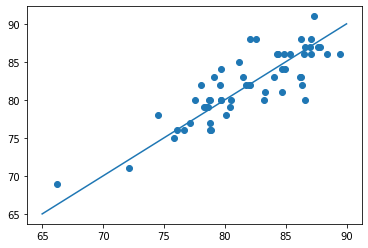

In [62]:
# Make predictions
y_pred = rf.predict(X_valid)

x = np.linspace(65, 90, 25)
y = x

plt.scatter(y_pred, y_valid)
plt.plot(x, y)

In [63]:
# Create a DataFrame of the feature importances 
rf_feats = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
rf_feats

,Feature Importance
Minutes Awake,0.106339
Time in Bed,0.218054
Minutes REM Sleep,0.582607
Minutes Deep Sleep,0.093000


In case of a random forest regression, feature importance represents a measure of how much a feature decreases impurity in the set decision trees. Remember that at every node in a tree the data has to be split so that similar value sof dependent variables end up in the same set after the split, thereby decreasing the impurity. For classification problems, the measure of impurity is called Gini Impurity, which is absed on information gain, and for regression problems the measure of impurity is variance. In a random forest regression, therefore, a more important feature is one that leads to a split in the dataset that leads to a strong decrease in variance.

Minutes REM sleep appears to be the feature that decreases impurity the most, followed by Time in Bed and then Minutes Awake and Minutes Deep Sleep. 

In this model, we have to be careful and not attach too much value to the feature importances of the model. The reason is that the features are correlated and therefore once one of the features is used as a predictor the importance of the others will automatically be reduced since a lot of the impurity that they could have removed is already removed by the feature that was considered before them and is highly correlated to them.

Next, let's look at Extreme Gradient Boosting.

## Extreme Gradient Boosting 

In [64]:
# Create regressor
xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fit model to training data
xgb = xgb_regressor.fit(X_train, y_train)

In [65]:
# Evaluate the performance
scoring(xgb, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.2075.
Mean Squared Error: 8.4496.
R^2 Score = 0.5676.
Accuracy = 97.27%.


In [66]:
# Create a DataFrame to inspect the feature importances again
xgb_feats = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
xgb_feats

,Feature Importance
Minutes Awake,0.190686
Time in Bed,0.280228
Minutes REM Sleep,0.407368
Minutes Deep Sleep,0.121719


Interestingly, Minutes REM Sleep is by far the most important feature again and, similar to the Random Forest, Time in Bed is the second most important.

## Introducing Cross-Validation

Because I am using a relatively small dataset of sleep scores and related features, a simple train test split may lead to over- or underfitting, meaning that the model may be either fitted too well to the training data or not well enough. One solution to this potential problem is to use Cross Validation. The general concept of Cross Validation is similar to that of splitting the data into training and testing data and can be thought of as a repeated train test split with subsequent testing of the model accuracy. In a train test split you train the model on one subset of the data and test it on the remaining data but you do that only once. In Cross Validation you perform multiple train test splits and for each split the test and training data are different. Basically, you split the data into a number of subsets, called folds, hold out one set at a time, train the model on the remaining data and test it on the hold out set. You repeat these steps until you have used every subset as the test set, i.e. by definition the number of times you perform these steps is equal to the number of folds you split the dataset into.

In [67]:
# Redefine the models to be tested
mlr_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=500, random_state=420)
xgb_reg = xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)

In [68]:
# Put the models in a list to be used for cross validation
models = [mlr_reg, rf_reg, xgb_reg]

In [79]:
# Define a function that runs cross-validations for all models that are given to it and returns their accuarcies
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    for model in models:
        mae = -round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv).mean(),4)
        maes.append(np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4))
        mse = -round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv).mean(),4)
        mses.append(np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4))
        r2 = round(cross_val_score(model, X, y, scoring='r2', cv=cv).mean(),4)
        r2s.append(np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4))
        acc = round((100 - (100 * (mae * len(X))) / sum(y)).mean(), 4)
        accs.append(np.round((100 - (100 * (mae * len(X))) / sum(y)), 4))
        cv_accuracies[str(model)] = [mae, mse, r2, acc]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

In [80]:
# Run the cross-validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 5)

In [81]:
# Change the columns of the compariosn table and return it
comp.columns = ['Multiple Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
comp

,Multiple Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,2.1363,2.2310,2.2977
Mean Squared Error,7.5546,8.5698,8.5201
R^2,0.7123,0.6768,0.6720
Accuracy,97.3854,97.2695,97.1878


Interestingly, compared to the results achieved with one simple train test split, MLR has the highest R^2 and Random Forest ha sthe lowest. Let's have a closer look at the R^2 of every fold of the cross-validation.

In [88]:
# Create DataFrame for all R^2s
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold'])

# Add a column for the averages
r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)
r2_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,Average
Multiple Linear Regression,0.5936,0.6903,0.7581,0.7948,0.7247,0.7123
Random Forest,0.6115,0.6255,0.7465,0.7400,0.6606,0.6768
Extreme Gradient Boosting,0.5224,0.6621,0.7621,0.7753,0.6382,0.6720


As the above table shows, R^2s fluctuate a lot depending on which subset is used as the holdout set, i.e. the validation set and which ones are used as the training sets. 

## Cross-Validation with Shuffling

When looking at the average of the crass validation scores for the three different models inlcuded in this analysis one may wonder why they are so different from those obtained using the simple train test split (or, in our case the train validation split). One possible explanation is that by default, the cross validation score function does not shuffle the dataset before splitting it into subsets/folds whereas the train test split function shuffles the data before splitting it by default. In order to make the two more comparable I will rerun the cross validation comparison using K-fold cross-validation with shuffled data.

In [ ]:
# Define the K-fold cross-validator
cval = KFold(n_splits=5, shuffle=True, random_state=420)

In [ ]:
# Redefine the models to be tested
mlr_regr = LinearRegression()
rf_regr = RandomForestRegressor(n_estimators=500, random_state=420)
xgb_regr = xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)

In [ ]:
# Put the models in a list to be used for cross validation
models_shuffle = [mlr_regr, rf_regr, xgb_regr]

In [ ]:
# Run the cross-validation comparison with the models used in this analysis
comp_shuffle, maes_shuffle, mses_shuffle, r2s_shuffle = cv_comparison(models_shuffle, X_train_temp, y_train_temp, cval)

In [ ]:
# Change the columns of the compariosn table and return it
comp_shuffle.columns = ['Multiple Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
comp_shuffle

In [ ]:
# Create DataFrame for all R^2s
r2_comp_shuffle = pd.DataFrame(r2s_shuffle, index=comp_shuffle.columns, columns=['1st Fold', '2nd Fold', '3rd Fold',
                                                                                 '4th Fold','5th Fold'])

# Add a column for the averages
r2_comp_shuffle['Average'] = np.round(r2_comp_shuffle.mean(axis=1),4)
r2_comp_shuffle

## Hyperparameter Optimization using Grid Search

Most Machine Learning models have hyperparameters, which can be tweaked to reach more optimal performace of the model. Scikit-Learn provides sensible defaults for these hyperparameters but there is no one-size-fits-all. Figuring out good hyperparameters in theory is nearly impossible which is why the best and fastest way to optimise hyperparameters is through experiments.

Hyperparameter tuning builds on the concept of cross-validation in order to account for overfitting. Just like for model evaluation itself, if we tried to optimise the hyperparameters used in a model solely on one pair of training and validation data we may tune the hyperparameters in a way that fits the model extremely well to the one validation set but the model may perform poorly when applied beyond the validation set. Cross-validation takes car eof this problem.

More specifically, the type of hyperparameter tuning that I will use is called "Random Search Cross Validation". Essentially, how this works is we first define a range of values for the hyperparamaters that we would like to tune. We then combine all the ranges for the hyperparameters we want to tune in a grid. The Random Search Cross Validation then picks random values from that grid, uses them as the values for the hyperparameters, runs a cross validation using the model with the randomly selected hyperparameters and evaluate sthe resulting score. We can specify how many random cross validations we want to include, keeping in mind that more random cross validations increase the likelihood of finding optimal hyperparameters but are also take more time and computational power. 

Because the Multiple Linear regression model technically does not have hyperparameters that we can optimise, I will focus on the hyperparameters of the Random Forest and the Extreme Gradient Boosting models.

## Hyperparameter Optimisation for Random Forest

Before we can set up ranges of values for the different hyperparameters we need to decide which hyperparemeters we want to try and optimise. A good place to start is to look at the official documentation (LINK) and think about which hyperparameters could be important for our model.

I will try to adjust the following hyperparameters: n_estimators, max_features, max_depth, criterion, min_samples_split, bootstrap, min_impurity_decrease.

In [179]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['mse', 'mae']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

In [180]:
# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1500, 2000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'mae'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

Previously, I used a 5-fold cross-validation but because that reduces the size of the training and validation tests quite a bit I'm going to use a 3-fold cross-validation now. I will search across 100 different combinations, meaning that a total of 300 models will be evaluated (3 folds for 100 combinations).

In [181]:
# Create the model to be tuned
rf_base = RandomForestRegressor()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, n_iter = 100, cv = 3,
                              verbose = 2, random_state = 420, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_temp, y_train_temp)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_impurity_decrease': [0.0, 0.05,
                                                                  0.1],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1500, 2000]},
        

In [183]:
# View the best parameters from the random search
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_impurity_decrease': 0.0,
 'max_features': 'log2',
 'max_depth': 55,
 'criterion': 'mse',
 'bootstrap': True}

In the final model, which we train on the entire training set and test on the up until this point completely unseen test data, we will use the above hyperparameters.

## Hyperparameter Optimisation for Extreme Gradient Boosting

For the Extreme Gradient Booster I will try to change the following hyperparameters: n_estimators, max_depth, min_child_weight, tree_method, eta, objective, n_thread, seed, gamma

In [191]:
# Number of trees in Random Forest
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

In [192]:
# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

xgb_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
 'eta': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6],
 'gamma': [0, 0, 0, 0, 0, 0],
 'objective': ['reg:squarederror', 'reg:squaredlogerror']}

One of the strengths of Extreme Gradient Boosting is execution speed, it tends to be much faster than Random forest models, which is why I will run 500 iterations instead of 100, resulting in 1500 models being evaluated (500 iterations with 3 folds).

In [194]:
# Create the model to be tuned
xgb_base = XGBRegressor()

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, n_iter = 500, cv = 3,
                              verbose = 2, random_state = 420, n_jobs = -1)

# Fit the random search model
xgb_random.fit(X_train_temp, y_train_temp)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   param_distributions={'eta': [0.1, 0.2, 0.30000000000000004,
                                                0.4, 0.5, 0.6],
                                        'gamma'

In [197]:
# Get the optimal parameters
xgb_random.best_params_

{'tree_method': 'auto',
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 8,
 'max_depth': 2,
 'gamma': 0,
 'eta': 0.1}

## Finally using the test data

After inspecting the performance of the three different models used in this analysis and performing hpyerparameter tuning, it's time to try out how good these models really are, this time using the test set for evaluating model performance.

In what follows I will train the models on the entire 80% of the original dataset as the training set and test it on the 20% hold out set that we have not touched up until now. I will use the optimal hyperparameters found through randomised grid search for Random Forest and Extreme Gradient Booster.

In [185]:
# Create the final multiple linear regression
mlr_final = LinearRegression()

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 1000,
                                 min_samples_split = 5,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'log2',
                                 max_depth = 55,
                                 criterion = 'mse',
                                 bootstrap = True,
                                 random_state = 420)

In [198]:
# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'auto',
                         objective = 'reg:squarederror',
                         n_estimators = 400,
                         min_child_weight = 8,
                         max_depth = 2,
                         gamma = 0,
                         eta = 0.1)

In [186]:
# Train the models using 80% of the original data
mlr_final.fit(X_train_temp, y_train_temp)
rf_final.fit(X_train_temp, y_train_temp)

RandomForestRegressor(max_depth=55, max_features='log2', min_samples_split=5,
                      n_estimators=1000, random_state=420)

In [199]:
# Train the final XGB using 80% of the original data
xgb_final.fit(X_train_temp, y_train_temp)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=2,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='auto', validate_parameters=1, verbosity=None)

In [187]:
# Measure the performance for the final MLR
scoring(mlr_final, X_test, y_test)

Model Performance
Mean Absolute Error: 2.3131.
Mean Squared Error: 8.3655.
R^2 Score = 0.7351.
Accuracy = 97.11%.


In [188]:
# Measure the performance for the final RF
scoring(rf_final, X_test, y_test)

Model Performance
Mean Absolute Error: 1.9821.
Mean Squared Error: 6.8002.
R^2 Score = 0.7846.
Accuracy = 97.51%.


In [200]:
# Measure the performance for the final RF
scoring(xgb_final, X_test, y_test)

Model Performance
Mean Absolute Error: 2.3313.
Mean Squared Error: 8.8268.
R^2 Score = 0.7205.
Accuracy = 97.05%.


In [201]:
# Define a function that runs cross-validations for all models that are given to it and returns their accuarcies
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = mean_absolute_error(test_labels, predictions)
        mse = mean_squared_error(test_labels, predictions)
        r2 = r2_score(test_labels, predictions)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = 100 - mape
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [203]:
# Call the compariosn function with the three final models
final_scores = final_comparison([mlr_final, rf_final, xgb_final], X_test, y_test)
final_scores.columns  = ['Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
final_scores

,Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,2.313115,1.982062,2.331275
Mean Squared Error,8.365475,6.800209,8.826827
R^2,0.735067,0.784639,0.720456
Accuracy,97.111301,97.509763,97.054704
